<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

# Install

In [1]:
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

     |████████████████████████████████| 51kB 2.4MB/s 


In [2]:
!pip install treeinterpreter

# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import random

from pprint import pprint
from subprocess import call
from IPython.display import Image

from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split

from treeinterpreter import treeinterpreter as ti
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from sklearn.tree import export_graphviz
from dtreeviz.trees import *

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Decision Trees

## Algorithm
![](https://www.kdnuggets.com/wp-content/uploads/dt-induction-algo.jpg)

![](https://pbs.twimg.com/media/ECoDmPPXUAA3Yb2.jpg)

## Entropy
![](https://miro.medium.com/max/565/1*M15RZMSk8nGEyOnD8haF-A.png)

## Information Gain
![](http://fileservice.slidewiki.org/media/images/25/3043.png?filter=Resize-width-384.16666666667)

# Regression

## Data

In [4]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['TARGET'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
X = boston_df.drop('TARGET', axis=1)
y = boston_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Metrics

In [7]:
def regression_metrics(truth, predictions):
    mae  = mean_absolute_error(truth, predictions)
    mse  = mean_squared_error(truth,  predictions)
    rmse = math.sqrt(mse)

    # Print out error for predictions
    print('MAE      : {:.3f}'.format(mae))
    print('MSE      : {:.3f}'.format(mse))
    print('RMSE     : {:.3f}'.format(rmse))

    # Compute Accuracy
    errors = abs(truth - predictions)
    mape = 100 * (errors / truth)
    accuracy = 100 - np.mean(mape)
    print('Accuracy : {:.2f}%'.format(accuracy))
    
    return (mae, mse, rmse, accuracy)

## Model

In [8]:
dt = DecisionTreeRegressor(random_state=301)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=301, splitter='best')

In [9]:
preds = dt.predict(X_test)
mae, mse, rmse, accuracy = regression_metrics(y_test, preds)

MAE      : 3.738
MSE      : 34.531
RMSE     : 5.876
Accuracy : 80.75%


## Residuals

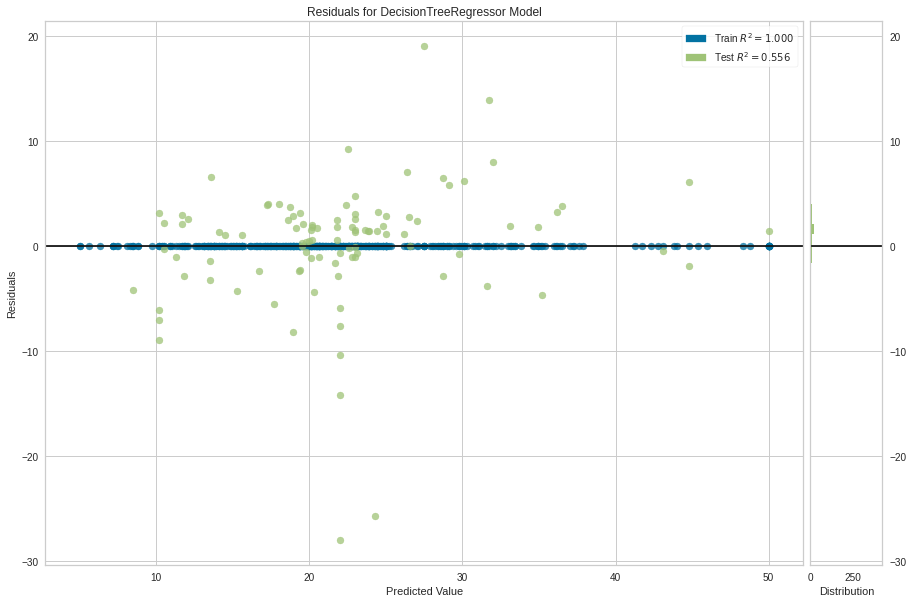

In [10]:
plt.figure(figsize=(15,10))
visualizer = ResidualsPlot(dt)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

## GraphViz

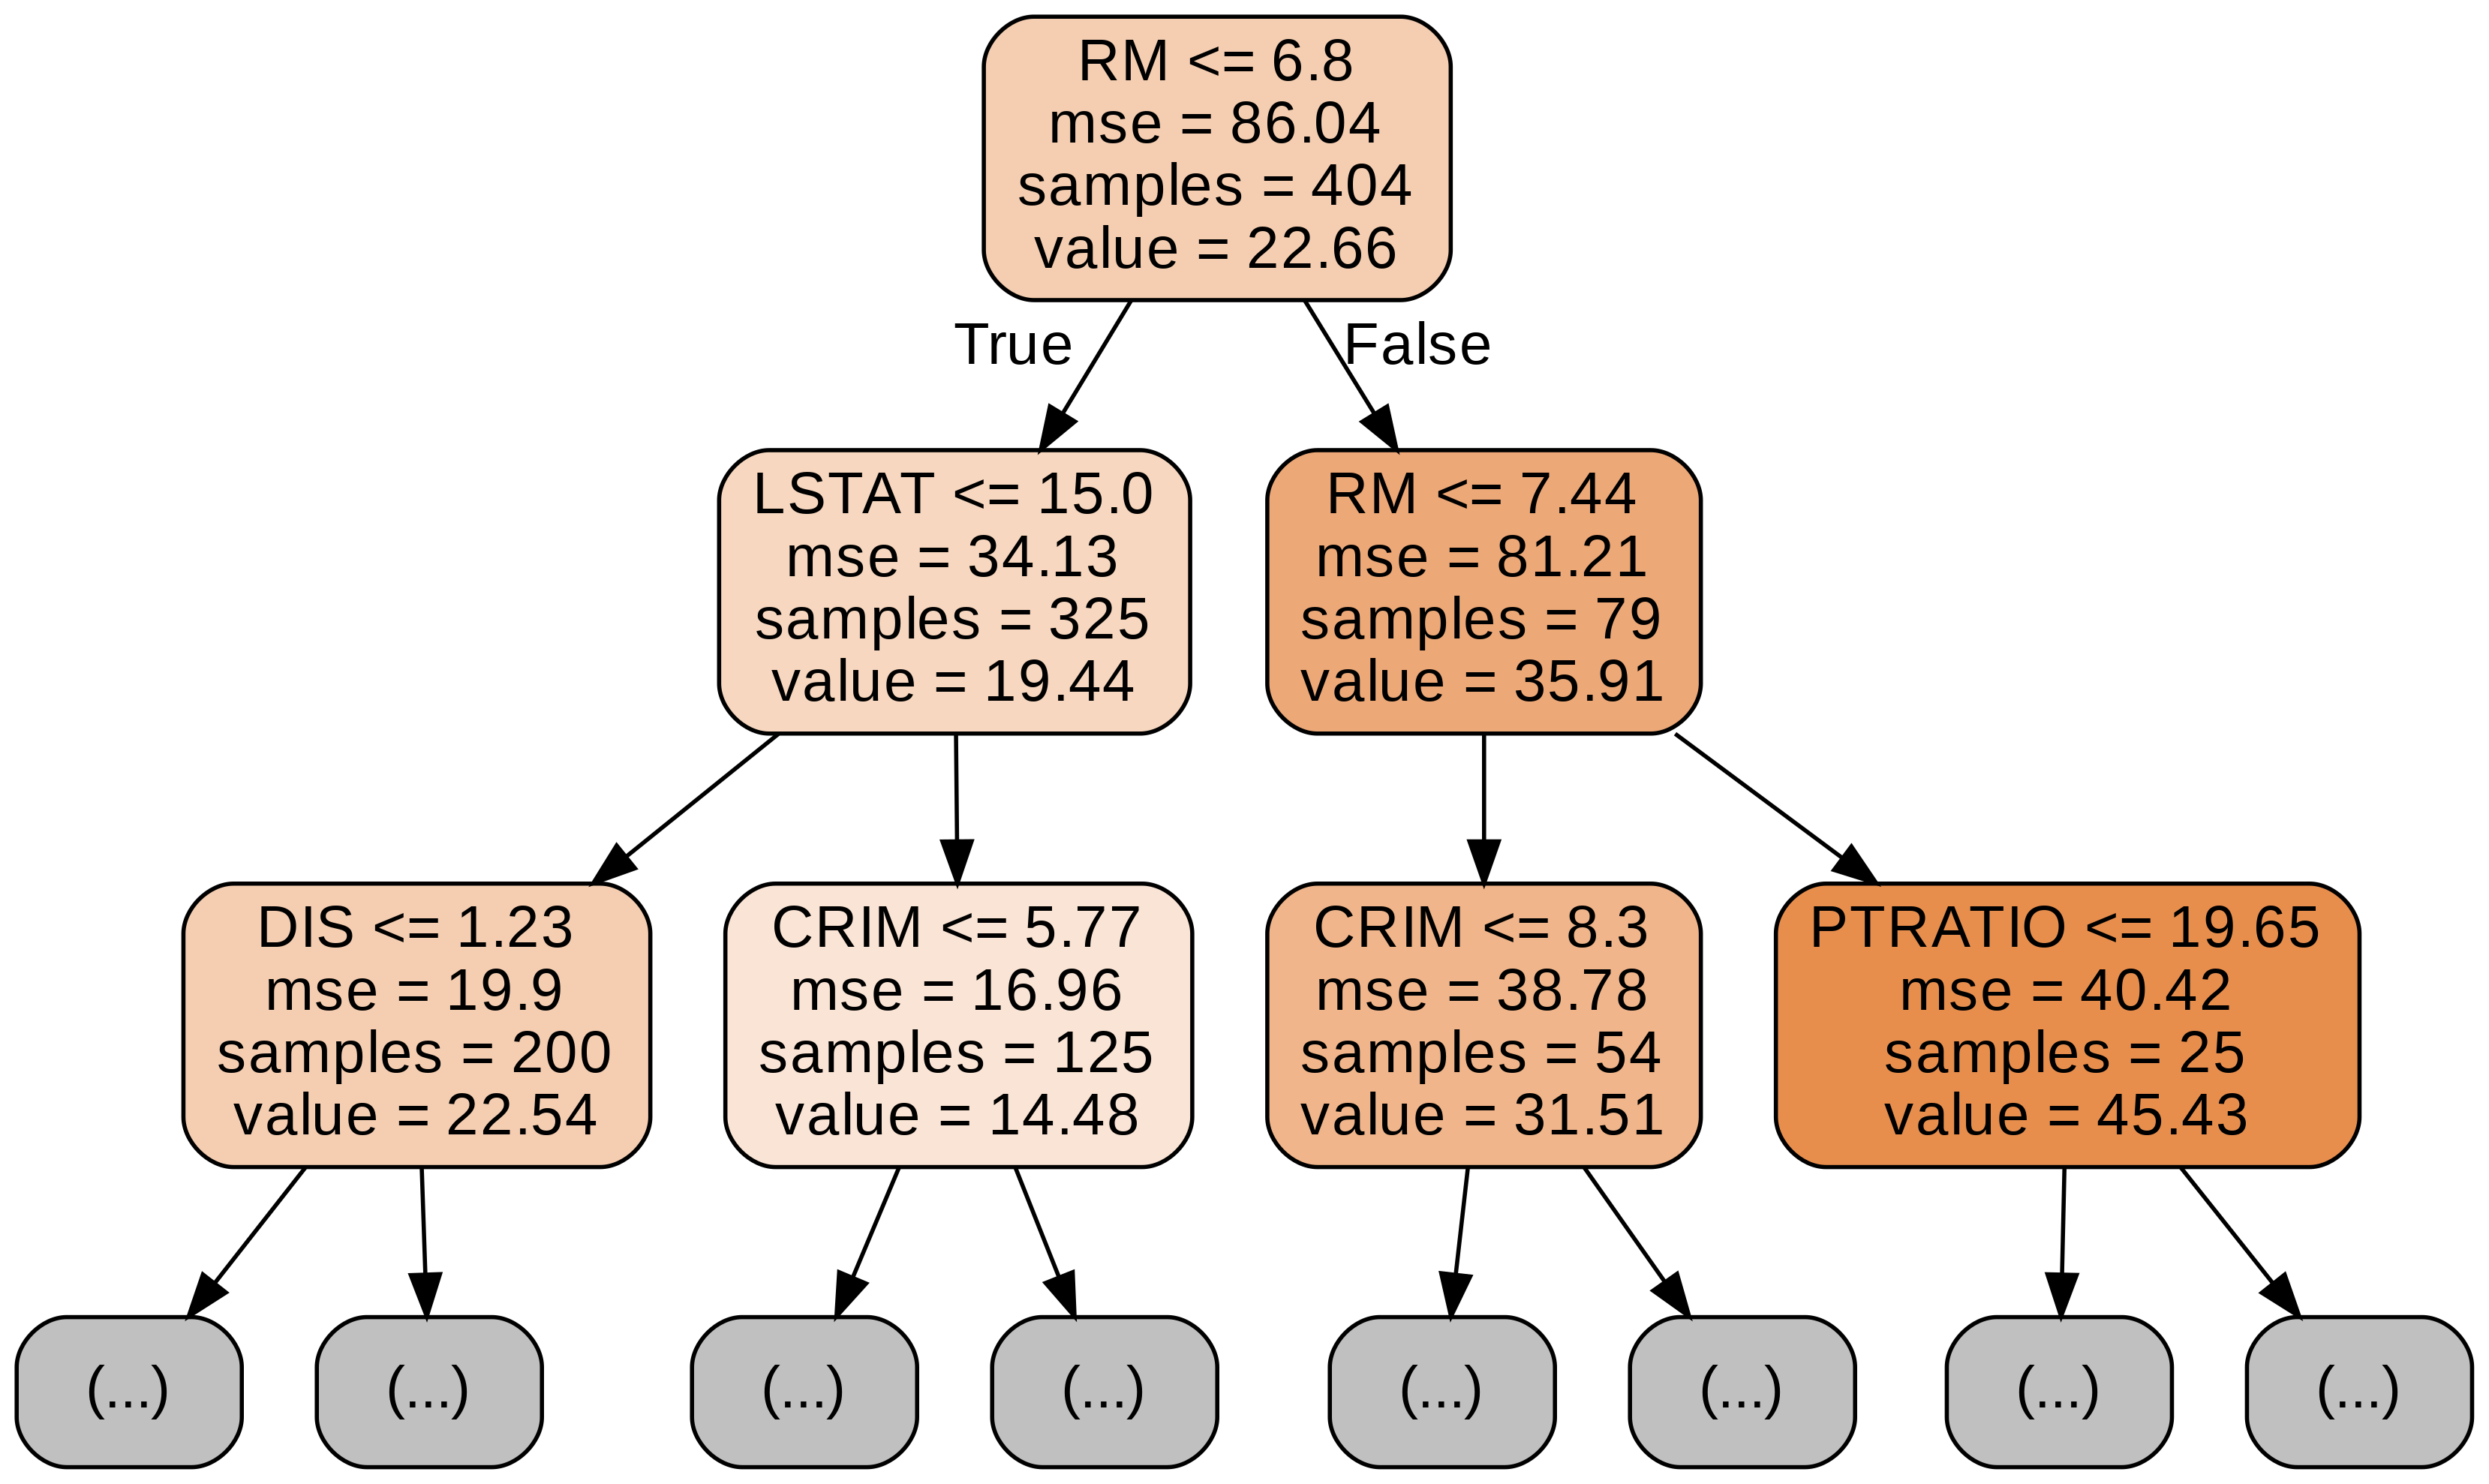

In [11]:
export_graphviz(dt, out_file='dtree.dot', 
                feature_names = X_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=2)
call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=400'])
Image(filename = './dtree.png')

## Decision Path
* Textual traversal

In [12]:
X_sample  = pd.DataFrame(X_test.copy().reset_index(drop=True).loc[0]).T
predicted = dt.predict(X_sample)
sample_id = 0

n_nodes        = dt.tree_.node_count
children_left  = dt.tree_.children_left
children_right = dt.tree_.children_right
feature        = dt.tree_.feature
threshold      = dt.tree_.threshold

node_indicator = dt.decision_path([X_sample.iloc[0]])
leave_id       = dt.apply([X_sample.iloc[0]])
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]
print('Values for Sample\n', X_sample.T, '\n')
print('Rules used to predict')
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if X_sample.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("Node[%3s] %10s = %10s %3s %10s"
          % (node_id,
             X_test.columns[feature[node_id]],
             X_test.iloc[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))
print('Predicted : %s' % predicted)

Values for Sample
                  0
CRIM       3.56868
ZN         0.00000
INDUS     18.10000
CHAS       0.00000
NOX        0.58000
RM         6.43700
AGE       75.00000
DIS        2.89650
RAD       24.00000
TAX      666.00000
PTRATIO   20.20000
B        393.37000
LSTAT     14.36000 

Rules used to predict
Node[  0]         RM =      6.437  <= 6.797000169754028
Node[  1]      LSTAT =      14.36  <=       15.0
Node[  2]        DIS =     2.8965   > 1.227150022983551
Node[  4]         RM =      6.437  <= 6.542999982833862
Node[  5]      LSTAT =      14.36   > 7.569999933242798
Node[ 71]       CRIM =    3.56868  <= 25.99779987335205
Node[ 72]    PTRATIO =       20.2  <= 20.949999809265137
Node[ 73]         RM =      6.437   > 6.061500072479248
Node[203]        TAX =      666.0   >      357.0
Node[249]    PTRATIO =       20.2   > 15.299999713897705
Node[255]        NOX =       0.58  <= 0.7414999902248383
Node[256]         RM =      6.437   > 6.343999862670898
Node[284]        AGE =       7

## DTreeViz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


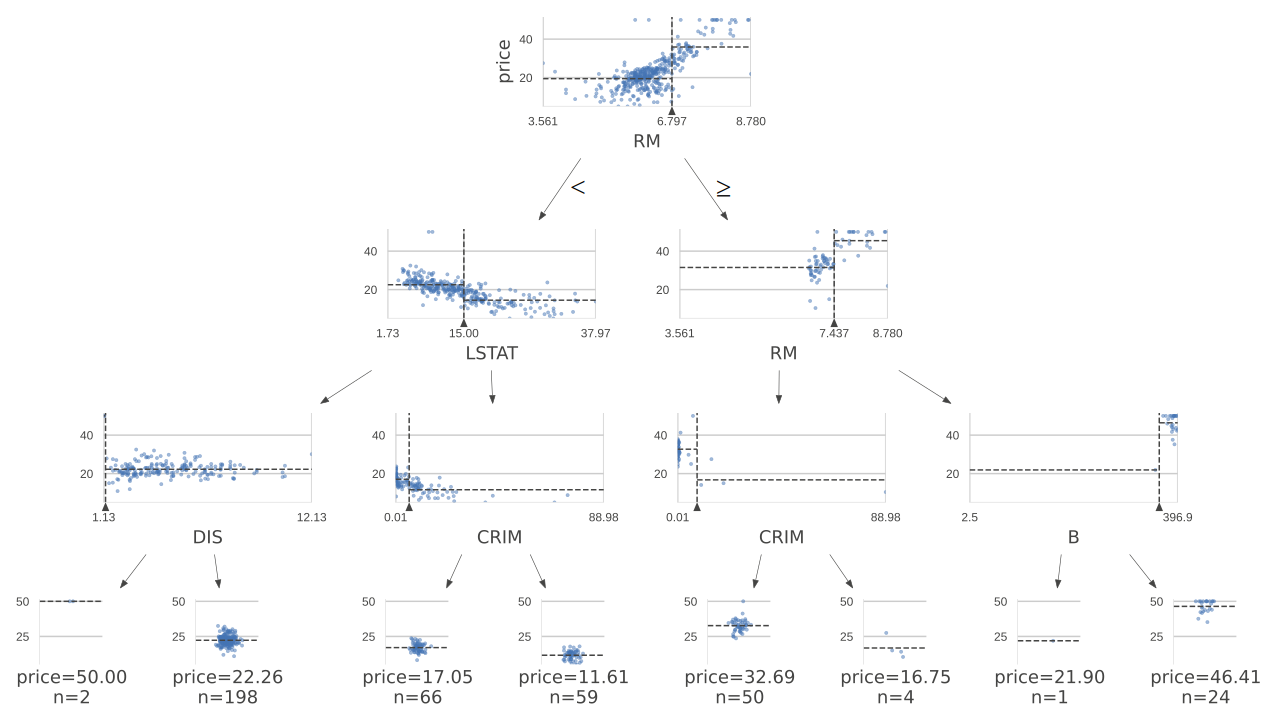

In [13]:
regress = DecisionTreeRegressor(max_depth=3)
regress.fit(X_train, y_train)
viz = dtreeviz(regress, X_train, y_train,
               target_name = 'price',
               feature_names=boston.feature_names,
               scale=2)
viz

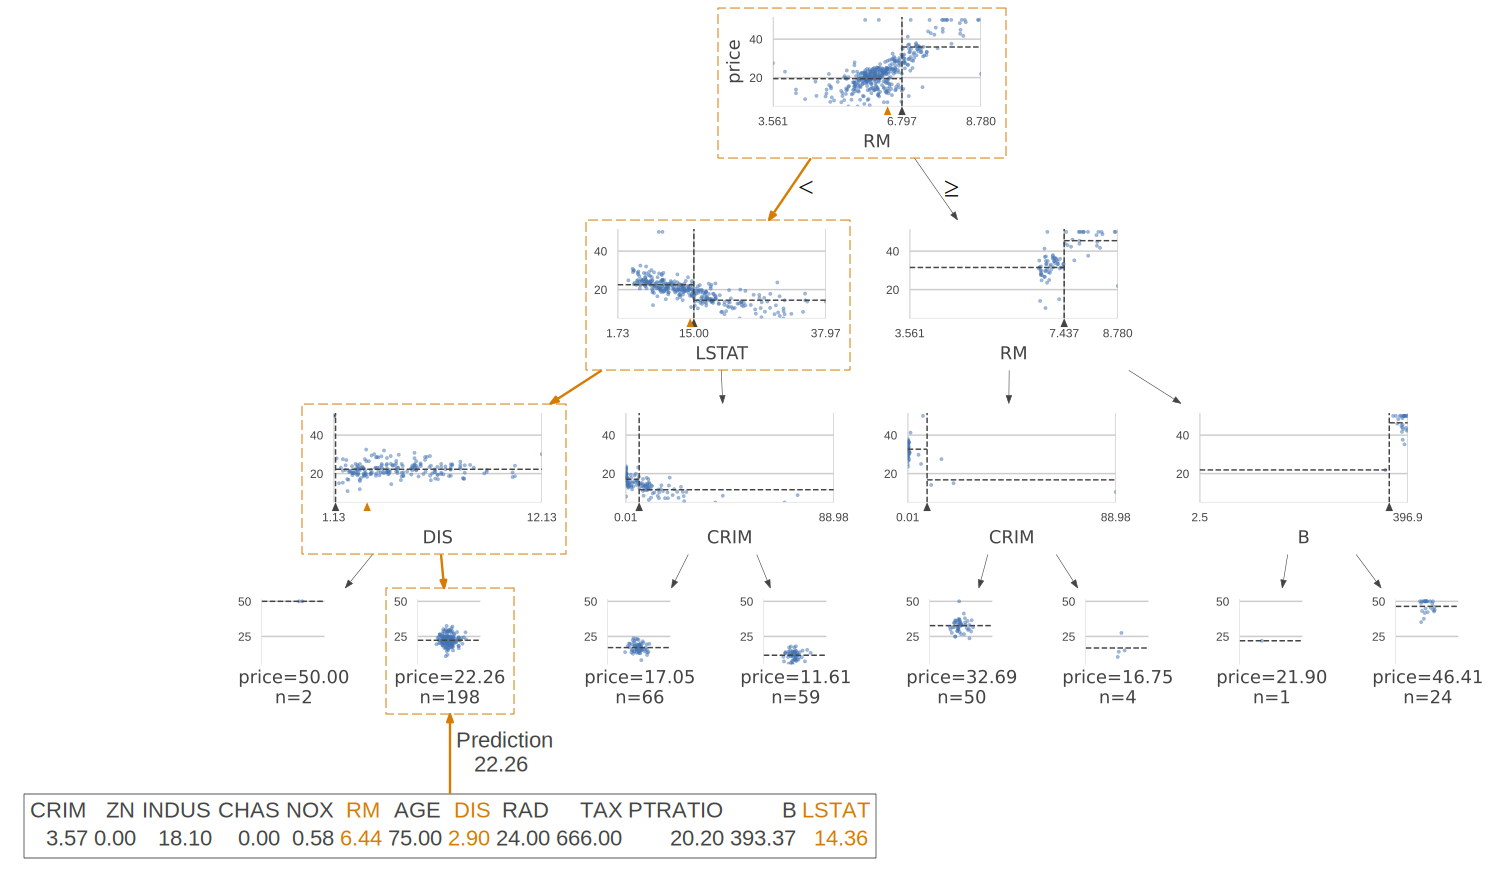

In [14]:
X_instance = X_test.iloc[0]
viz = dtreeviz(regress, X_train, y_train,
               target_name = 'price',
               feature_names=boston.feature_names,
               scale=2,
               X=X_instance)
viz

# Classification

## Data

In [15]:
iris = load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [16]:
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['TARGET'] = iris['target']
iris_df['TARGET'] = iris_df.TARGET.astype('category')
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),TARGET
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [17]:
X = iris_df.drop('TARGET', axis=1)
y = iris_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Metrics

In [18]:
def classification_metrics(truth, predictions):
    accuracy = accuracy_score(truth, predictions)
    return accuracy

## Model

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## GraphViz

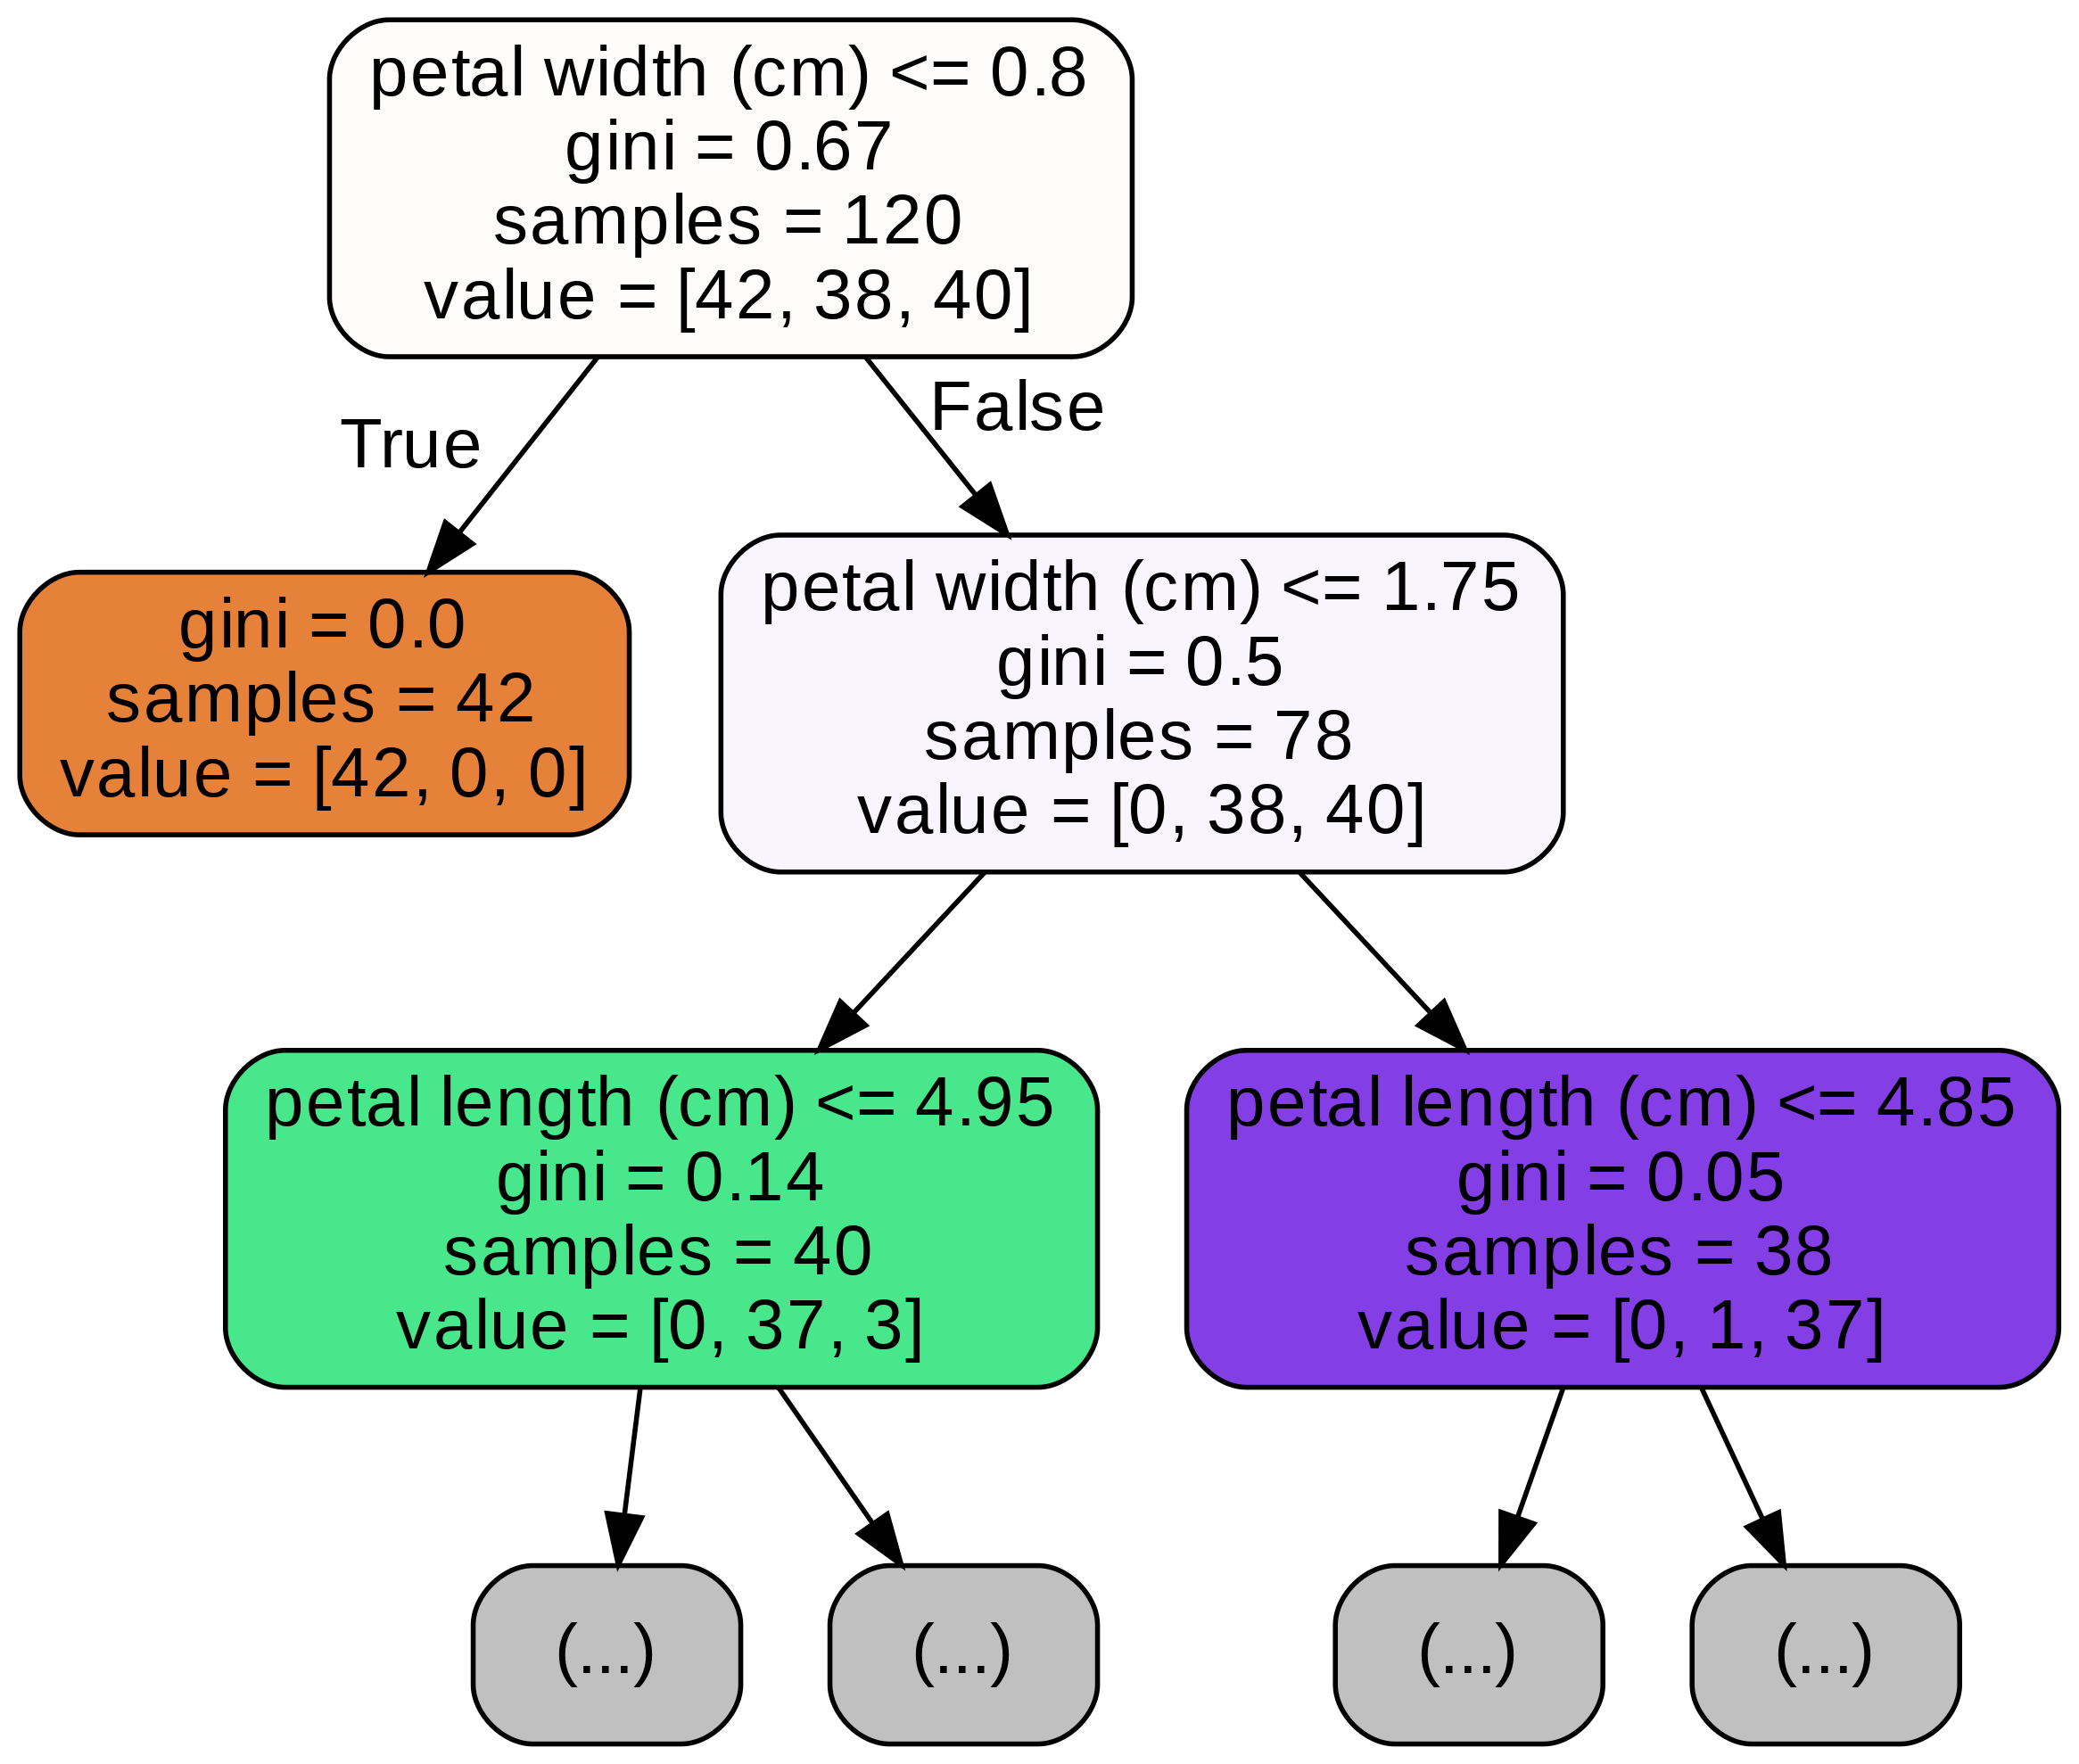

In [20]:
export_graphviz(dt, out_file='dtree.dot', 
                feature_names = X_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=2)
call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=400'])
Image(filename = './dtree.png')

## Decision Path

In [21]:
X_sample  = pd.DataFrame(X_test.copy().reset_index(drop=True).loc[0]).T
predicted = dt.predict(X_sample)
sample_id = 0

n_nodes        = dt.tree_.node_count
children_left  = dt.tree_.children_left
children_right = dt.tree_.children_right
feature        = dt.tree_.feature
threshold      = dt.tree_.threshold

node_indicator = dt.decision_path([X_sample.iloc[0]])
leave_id       = dt.apply([X_sample.iloc[0]])
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]
print('Values for Sample\n', X_sample.T, '\n')
print('Rules used to predict')
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if X_sample.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("Node[%3s] %10s = %10s %3s %10s"
          % (node_id,
             X_test.columns[feature[node_id]],
             X_test.iloc[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))
print('Predicted : %s' % predicted)

Values for Sample
                      0
sepal length (cm)  6.1
sepal width (cm)   2.8
petal length (cm)  4.7
petal width (cm)   1.2 

Rules used to predict
Node[  0] petal width (cm) =        1.2   > 0.800000011920929
Node[  2] petal width (cm) =        1.2  <=       1.75
Node[  3] petal length (cm) =        4.7  <= 4.950000047683716
Predicted : [1]


## DTreeViz

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


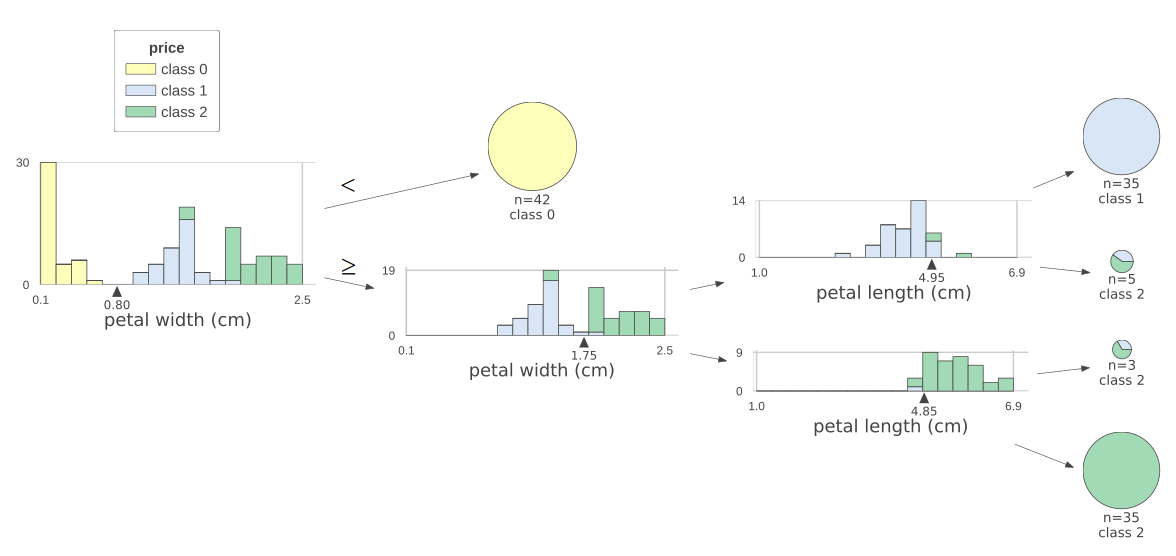

In [22]:
regress = DecisionTreeClassifier(max_depth=3)
regress.fit(X_train, y_train)
viz = dtreeviz(regress, X_train, y_train,
               target_name = 'price',
               feature_names=iris.feature_names,
               scale=2,
               orientation='LR')
viz

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


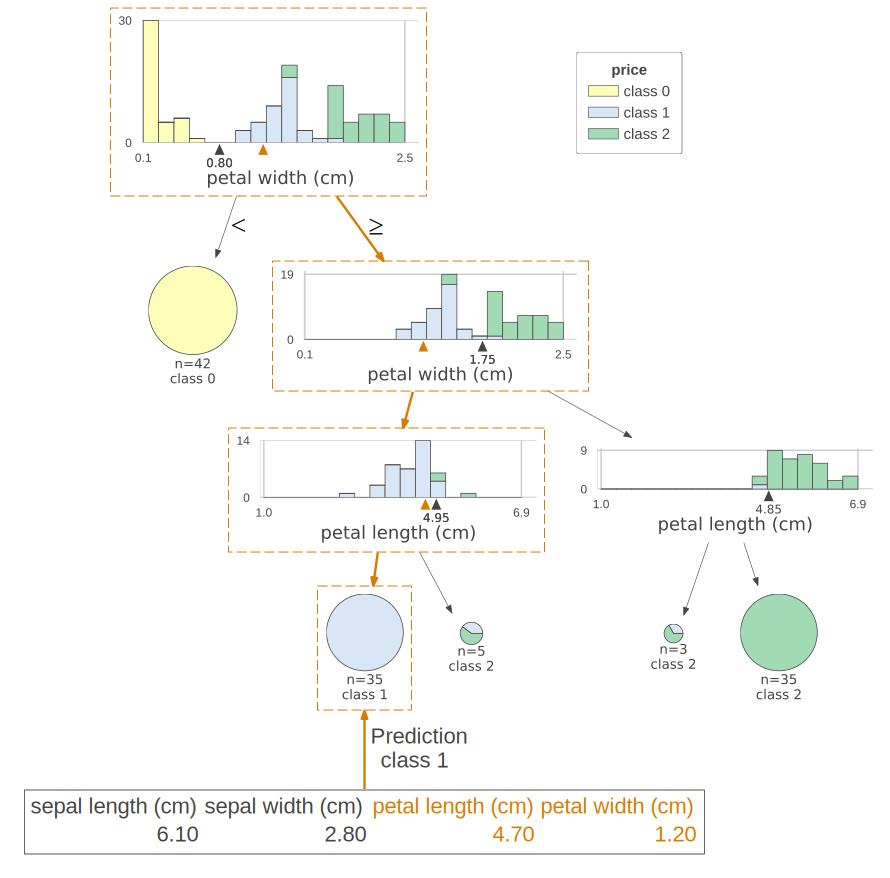

In [23]:
X_instance = X_test.iloc[0]
viz = dtreeviz(regress, X_train, y_train,
               target_name = 'price',
               feature_names=iris.feature_names,
               scale=2,
               X=X_instance)
viz